## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_windowsize = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-16 23:58:31,049] A new study created in memory with name: no-name-7c3c83fd-8081-4e44-a853-21a00eb5d3f6


8/8 [==============================] - 1s 7ms/step


[I 2023-06-16 23:58:44,523] Trial 0 finished with value: 237.42058107845685 and parameters: {'window_size': 72, 'tcn_filters': 58, 'tcn_kernel_size': 5, 'dropout_rate': 0.4471540094046583, 'attention_dim': 31}. Best is trial 0 with value: 237.42058107845685.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-16 23:58:56,915] Trial 1 finished with value: 99.37954049871287 and parameters: {'window_size': 26, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.32748291127255014, 'attention_dim': 30}. Best is trial 1 with value: 99.37954049871287.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-16 23:59:03,192] Trial 2 finished with value: 46.955349109194714 and parameters: {'window_size': 15, 'tcn_filters': 77, 'tcn_kernel_size': 5, 'dropout_rate': 0.2950767644484159, 'attention_dim': 8}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-16 23:59:07,127] Trial 3 finished with value: 127.94167543837374 and parameters: {'window_size': 25, 'tcn_filters': 33, 'tcn_kernel_size': 5, 'dropout_rate': 0.4087699688975541, 'attention_dim': 10}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-16 23:59:18,781] Trial 4 finished with value: 142.68049047932476 and parameters: {'window_size': 71, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.2682657093414769, 'attention_dim': 14}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-16 23:59:21,825] Trial 5 finished with value: 123.63420383349853 and parameters: {'window_size': 33, 'tcn_filters': 36, 'tcn_kernel_size': 4, 'dropout_rate': 0.4944056974398118, 'attention_dim': 18}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-16 23:59:33,357] Trial 6 finished with value: 179.89694339335082 and parameters: {'window_size': 83, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.47483521978245125, 'attention_dim': 21}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-16 23:59:38,992] Trial 7 finished with value: 239.53177254086935 and parameters: {'window_size': 83, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.4750630818737195, 'attention_dim': 17}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-16 23:59:45,432] Trial 8 finished with value: 49.575691897010174 and parameters: {'window_size': 17, 'tcn_filters': 93, 'tcn_kernel_size': 3, 'dropout_rate': 0.21981309106872265, 'attention_dim': 23}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-16 23:59:51,123] Trial 9 finished with value: 51.37938149560459 and parameters: {'window_size': 20, 'tcn_filters': 49, 'tcn_kernel_size': 4, 'dropout_rate': 0.2357260008993598, 'attention_dim': 19}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-16 23:59:57,573] Trial 10 finished with value: 199.34916199557497 and parameters: {'window_size': 48, 'tcn_filters': 70, 'tcn_kernel_size': 4, 'dropout_rate': 0.1209931627661511, 'attention_dim': 8}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:00:00,202] Trial 11 finished with value: 92.33805367409103 and parameters: {'window_size': 10, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.19779325415474708, 'attention_dim': 24}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:00:04,176] Trial 12 finished with value: 97.78817874743451 and parameters: {'window_size': 41, 'tcn_filters': 97, 'tcn_kernel_size': 3, 'dropout_rate': 0.33210182843626795, 'attention_dim': 25}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:00:08,713] Trial 13 finished with value: 56.86663699031852 and parameters: {'window_size': 12, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.19560656445029695, 'attention_dim': 13}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:00:15,386] Trial 14 finished with value: 193.07104258166373 and parameters: {'window_size': 58, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.29678429535973977, 'attention_dim': 26}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:00:27,048] Trial 15 finished with value: 127.08185755897746 and parameters: {'window_size': 38, 'tcn_filters': 62, 'tcn_kernel_size': 2, 'dropout_rate': 0.10780512352617624, 'attention_dim': 22}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:00:38,651] Trial 16 finished with value: 132.88611804891144 and parameters: {'window_size': 54, 'tcn_filters': 101, 'tcn_kernel_size': 5, 'dropout_rate': 0.3727605596806966, 'attention_dim': 14}. Best is trial 2 with value: 46.955349109194714.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:00:43,511] Trial 17 finished with value: 42.351519508414604 and parameters: {'window_size': 19, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.2575469609224233, 'attention_dim': 27}. Best is trial 17 with value: 42.351519508414604.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:01:05,363] Trial 18 finished with value: 247.81848922687814 and parameters: {'window_size': 98, 'tcn_filters': 72, 'tcn_kernel_size': 5, 'dropout_rate': 0.2712420807481028, 'attention_dim': 28}. Best is trial 17 with value: 42.351519508414604.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:01:17,029] Trial 19 finished with value: 67.8758851231368 and parameters: {'window_size': 31, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.3736200162004141, 'attention_dim': 28}. Best is trial 17 with value: 42.351519508414604.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:01:23,578] Trial 20 finished with value: 162.17888838436372 and parameters: {'window_size': 43, 'tcn_filters': 81, 'tcn_kernel_size': 5, 'dropout_rate': 0.15116969610311026, 'attention_dim': 32}. Best is trial 17 with value: 42.351519508414604.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:01:31,068] Trial 21 finished with value: 42.16648950265465 and parameters: {'window_size': 18, 'tcn_filters': 89, 'tcn_kernel_size': 3, 'dropout_rate': 0.22285641919385127, 'attention_dim': 23}. Best is trial 21 with value: 42.16648950265465.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:01:42,701] Trial 22 finished with value: 36.70387522291682 and parameters: {'window_size': 20, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.24822416967027414, 'attention_dim': 27}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:01:49,267] Trial 23 finished with value: 65.0000617294742 and parameters: {'window_size': 25, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.24031940639793045, 'attention_dim': 27}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:01:53,153] Trial 24 finished with value: 358.16814841956216 and parameters: {'window_size': 31, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.1733041291550782, 'attention_dim': 30}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:01:59,627] Trial 25 finished with value: 58.79944392436185 and parameters: {'window_size': 19, 'tcn_filters': 67, 'tcn_kernel_size': 3, 'dropout_rate': 0.2603817772499956, 'attention_dim': 25}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:02:06,139] Trial 26 finished with value: 52.044862330175356 and parameters: {'window_size': 10, 'tcn_filters': 56, 'tcn_kernel_size': 4, 'dropout_rate': 0.20879278446485916, 'attention_dim': 29}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:02:10,101] Trial 27 finished with value: 130.6034499312783 and parameters: {'window_size': 22, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.24740953583614758, 'attention_dim': 21}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:02:16,593] Trial 28 finished with value: 126.59532699444608 and parameters: {'window_size': 35, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.2224674779254009, 'attention_dim': 23}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:02:29,036] Trial 29 finished with value: 164.2313128480663 and parameters: {'window_size': 48, 'tcn_filters': 60, 'tcn_kernel_size': 3, 'dropout_rate': 0.18301279425702435, 'attention_dim': 32}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:02:35,610] Trial 30 finished with value: 244.17711356696796 and parameters: {'window_size': 64, 'tcn_filters': 52, 'tcn_kernel_size': 2, 'dropout_rate': 0.16946477319675107, 'attention_dim': 26}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:02:42,134] Trial 31 finished with value: 44.89862189160405 and parameters: {'window_size': 17, 'tcn_filters': 80, 'tcn_kernel_size': 5, 'dropout_rate': 0.3033597521963987, 'attention_dim': 16}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:02:48,699] Trial 32 finished with value: 59.43615337045419 and parameters: {'window_size': 25, 'tcn_filters': 92, 'tcn_kernel_size': 5, 'dropout_rate': 0.27321775135098547, 'attention_dim': 16}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:02:55,167] Trial 33 finished with value: 94.36827596991255 and parameters: {'window_size': 17, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.3095522758297194, 'attention_dim': 20}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:00,855] Trial 34 finished with value: 133.21052822179254 and parameters: {'window_size': 29, 'tcn_filters': 66, 'tcn_kernel_size': 5, 'dropout_rate': 0.22941299422412476, 'attention_dim': 30}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:03:06,389] Trial 35 finished with value: 49.84813099297965 and parameters: {'window_size': 16, 'tcn_filters': 76, 'tcn_kernel_size': 4, 'dropout_rate': 0.2854916702746225, 'attention_dim': 12}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:12,856] Trial 36 finished with value: 102.30092172223793 and parameters: {'window_size': 23, 'tcn_filters': 82, 'tcn_kernel_size': 5, 'dropout_rate': 0.2507305290132351, 'attention_dim': 16}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:20,476] Trial 37 finished with value: 83.10672616067235 and parameters: {'window_size': 27, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.3197229227672506, 'attention_dim': 27}. Best is trial 22 with value: 36.70387522291682.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:25,984] Trial 38 finished with value: 30.17042778158575 and parameters: {'window_size': 15, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.28777412244961204, 'attention_dim': 24}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:03:30,483] Trial 39 finished with value: 51.16253045636564 and parameters: {'window_size': 13, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.2567802342260326, 'attention_dim': 24}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:03:37,546] Trial 40 finished with value: 160.48304684796773 and parameters: {'window_size': 36, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.2821229293099965, 'attention_dim': 22}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:42,782] Trial 41 finished with value: 109.19150832610987 and parameters: {'window_size': 19, 'tcn_filters': 91, 'tcn_kernel_size': 4, 'dropout_rate': 0.2976790890336035, 'attention_dim': 19}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:03:49,548] Trial 42 finished with value: 167.3763829242849 and parameters: {'window_size': 13, 'tcn_filters': 97, 'tcn_kernel_size': 4, 'dropout_rate': 0.2203477976212889, 'attention_dim': 25}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:03:55,974] Trial 43 finished with value: 121.87208722750259 and parameters: {'window_size': 20, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.2673706898772815, 'attention_dim': 23}. Best is trial 38 with value: 30.17042778158575.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:04:02,878] Trial 44 finished with value: 26.77964985356266 and parameters: {'window_size': 16, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.24291776530179549, 'attention_dim': 28}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:04:09,381] Trial 45 finished with value: 82.56770399860784 and parameters: {'window_size': 28, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.24048297286589868, 'attention_dim': 29}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:04:14,726] Trial 46 finished with value: 94.64524921765367 and parameters: {'window_size': 10, 'tcn_filters': 40, 'tcn_kernel_size': 4, 'dropout_rate': 0.20643445869547355, 'attention_dim': 27}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:04:19,384] Trial 47 finished with value: 119.05294428494253 and parameters: {'window_size': 22, 'tcn_filters': 75, 'tcn_kernel_size': 4, 'dropout_rate': 0.23202988839618743, 'attention_dim': 26}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:04:25,740] Trial 48 finished with value: 86.8646762110097 and parameters: {'window_size': 15, 'tcn_filters': 99, 'tcn_kernel_size': 3, 'dropout_rate': 0.25565820403860384, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:04:32,661] Trial 49 finished with value: 127.50645580331438 and parameters: {'window_size': 77, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.28289474883153964, 'attention_dim': 31}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:04:39,188] Trial 50 finished with value: 273.5178179474739 and parameters: {'window_size': 39, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.2109718913544986, 'attention_dim': 29}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:04:43,664] Trial 51 finished with value: 54.96157490398394 and parameters: {'window_size': 15, 'tcn_filters': 68, 'tcn_kernel_size': 4, 'dropout_rate': 0.33148407574374256, 'attention_dim': 28}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:04:50,174] Trial 52 finished with value: 41.66102439321909 and parameters: {'window_size': 19, 'tcn_filters': 78, 'tcn_kernel_size': 5, 'dropout_rate': 0.3103382145953492, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:05:01,781] Trial 53 finished with value: 32.66453129252739 and parameters: {'window_size': 23, 'tcn_filters': 71, 'tcn_kernel_size': 4, 'dropout_rate': 0.26943489965653766, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:05:08,071] Trial 54 finished with value: 83.52737672120905 and parameters: {'window_size': 25, 'tcn_filters': 64, 'tcn_kernel_size': 3, 'dropout_rate': 0.2862680520792824, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:05:19,756] Trial 55 finished with value: 152.450647120107 and parameters: {'window_size': 32, 'tcn_filters': 70, 'tcn_kernel_size': 5, 'dropout_rate': 0.30975111085451223, 'attention_dim': 19}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:05:23,964] Trial 56 finished with value: 52.3870327991967 and parameters: {'window_size': 22, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.3428988686679924, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:05:30,840] Trial 57 finished with value: 28.292046554399548 and parameters: {'window_size': 13, 'tcn_filters': 77, 'tcn_kernel_size': 2, 'dropout_rate': 0.2713593383110245, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:05:34,847] Trial 58 finished with value: 47.29736157527098 and parameters: {'window_size': 14, 'tcn_filters': 57, 'tcn_kernel_size': 2, 'dropout_rate': 0.26918540276498654, 'attention_dim': 20}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:05:41,493] Trial 59 finished with value: 344.52450524559515 and parameters: {'window_size': 99, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.2931558739502229, 'attention_dim': 25}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:05:48,022] Trial 60 finished with value: 102.22093194502612 and parameters: {'window_size': 29, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.2462010316980115, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:05:54,645] Trial 61 finished with value: 42.254481577729514 and parameters: {'window_size': 11, 'tcn_filters': 78, 'tcn_kernel_size': 2, 'dropout_rate': 0.2323052050597441, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:06:07,355] Trial 62 finished with value: 51.82177351995534 and parameters: {'window_size': 20, 'tcn_filters': 85, 'tcn_kernel_size': 2, 'dropout_rate': 0.26312713312306824, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:06:13,981] Trial 63 finished with value: 51.68840940389116 and parameters: {'window_size': 17, 'tcn_filters': 95, 'tcn_kernel_size': 4, 'dropout_rate': 0.27363486379124413, 'attention_dim': 20}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:06:19,987] Trial 64 finished with value: 190.75937280039366 and parameters: {'window_size': 23, 'tcn_filters': 78, 'tcn_kernel_size': 3, 'dropout_rate': 0.24304337455076688, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:06:24,029] Trial 65 finished with value: 197.10477714321053 and parameters: {'window_size': 12, 'tcn_filters': 89, 'tcn_kernel_size': 4, 'dropout_rate': 0.22133658795884628, 'attention_dim': 26}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:06:30,582] Trial 66 finished with value: 129.12853481382953 and parameters: {'window_size': 19, 'tcn_filters': 72, 'tcn_kernel_size': 5, 'dropout_rate': 0.27870715514422184, 'attention_dim': 18}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:06:36,391] Trial 67 finished with value: 62.1932321836941 and parameters: {'window_size': 26, 'tcn_filters': 84, 'tcn_kernel_size': 3, 'dropout_rate': 0.2966745207177641, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 00:06:42,210] Trial 68 finished with value: 405.93032277461015 and parameters: {'window_size': 90, 'tcn_filters': 63, 'tcn_kernel_size': 2, 'dropout_rate': 0.25404940345764865, 'attention_dim': 25}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:06:48,902] Trial 69 finished with value: 134.02514130010047 and parameters: {'window_size': 34, 'tcn_filters': 79, 'tcn_kernel_size': 4, 'dropout_rate': 0.23524537626458397, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:07:01,742] Trial 70 finished with value: 149.06825713745232 and parameters: {'window_size': 58, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.31758345676091826, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:07:05,731] Trial 71 finished with value: 61.064317878161596 and parameters: {'window_size': 10, 'tcn_filters': 77, 'tcn_kernel_size': 2, 'dropout_rate': 0.2256523990280891, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:07:12,740] Trial 72 finished with value: 55.535490921481994 and parameters: {'window_size': 13, 'tcn_filters': 69, 'tcn_kernel_size': 2, 'dropout_rate': 0.2388936378273683, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:07:19,427] Trial 73 finished with value: 41.93861770476066 and parameters: {'window_size': 18, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.2659541170623599, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:07:23,881] Trial 74 finished with value: 42.426232266190006 and parameters: {'window_size': 17, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.27294744729956527, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:07:28,818] Trial 75 finished with value: 126.13238255410843 and parameters: {'window_size': 23, 'tcn_filters': 65, 'tcn_kernel_size': 2, 'dropout_rate': 0.25817382314571335, 'attention_dim': 26}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:07:32,802] Trial 76 finished with value: 124.5818693810966 and parameters: {'window_size': 20, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.2617634627273542, 'attention_dim': 18}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:07:37,762] Trial 77 finished with value: 56.66697909833731 and parameters: {'window_size': 15, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.28945915564051217, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 1s 5ms/step


[I 2023-06-17 00:07:45,567] Trial 78 finished with value: 262.38208964273 and parameters: {'window_size': 69, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.30437234459429663, 'attention_dim': 28}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 00:07:57,775] Trial 79 finished with value: 150.40614009993 and parameters: {'window_size': 47, 'tcn_filters': 86, 'tcn_kernel_size': 4, 'dropout_rate': 0.24626599959203788, 'attention_dim': 20}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:02,194] Trial 80 finished with value: 115.3627854596817 and parameters: {'window_size': 17, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.2753799344970948, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:08,816] Trial 81 finished with value: 70.05470391094103 and parameters: {'window_size': 11, 'tcn_filters': 77, 'tcn_kernel_size': 2, 'dropout_rate': 0.23160602088315757, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:16,828] Trial 82 finished with value: 39.56920258220092 and parameters: {'window_size': 12, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.21612448415156368, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:23,548] Trial 83 finished with value: 59.583811366382065 and parameters: {'window_size': 14, 'tcn_filters': 82, 'tcn_kernel_size': 2, 'dropout_rate': 0.21118970968963774, 'attention_dim': 25}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:30,572] Trial 84 finished with value: 47.440793045611024 and parameters: {'window_size': 19, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.20049384774771684, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:08:36,592] Trial 85 finished with value: 80.14680773176353 and parameters: {'window_size': 24, 'tcn_filters': 61, 'tcn_kernel_size': 2, 'dropout_rate': 0.21688136634024843, 'attention_dim': 19}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 00:08:43,518] Trial 86 finished with value: 48.02444899686526 and parameters: {'window_size': 30, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.24989313148321451, 'attention_dim': 27}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:08:51,063] Trial 87 finished with value: 176.19280325376502 and parameters: {'window_size': 21, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.26569140525574353, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:55,208] Trial 88 finished with value: 58.71948305328506 and parameters: {'window_size': 18, 'tcn_filters': 75, 'tcn_kernel_size': 3, 'dropout_rate': 0.2893847533512478, 'attention_dim': 31}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:08:59,291] Trial 89 finished with value: 103.51099848268883 and parameters: {'window_size': 15, 'tcn_filters': 79, 'tcn_kernel_size': 5, 'dropout_rate': 0.2809396014064548, 'attention_dim': 26}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 00:09:11,286] Trial 90 finished with value: 194.94150954172034 and parameters: {'window_size': 27, 'tcn_filters': 100, 'tcn_kernel_size': 4, 'dropout_rate': 0.19637245216617943, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:09:17,919] Trial 91 finished with value: 36.289279616526386 and parameters: {'window_size': 13, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.22918548907278796, 'attention_dim': 23}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:09:22,370] Trial 92 finished with value: 90.65523655454886 and parameters: {'window_size': 12, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.22679971351314934, 'attention_dim': 9}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:09:28,965] Trial 93 finished with value: 71.30637577030012 and parameters: {'window_size': 16, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.2513915415439352, 'attention_dim': 22}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:09:33,732] Trial 94 finished with value: 71.46727313935696 and parameters: {'window_size': 14, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.24048652885414812, 'attention_dim': 25}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:09:43,109] Trial 95 finished with value: 42.488912357431886 and parameters: {'window_size': 22, 'tcn_filters': 73, 'tcn_kernel_size': 2, 'dropout_rate': 0.26156141630995655, 'attention_dim': 21}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:09:49,774] Trial 96 finished with value: 30.7350070501254 and parameters: {'window_size': 12, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.22084772263288457, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:09:55,871] Trial 97 finished with value: 36.36402092524559 and parameters: {'window_size': 12, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.18746341160339294, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 00:09:59,864] Trial 98 finished with value: 32.17535233332886 and parameters: {'window_size': 10, 'tcn_filters': 70, 'tcn_kernel_size': 2, 'dropout_rate': 0.18735320085212528, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 00:10:05,746] Trial 99 finished with value: 41.175902659781485 and parameters: {'window_size': 10, 'tcn_filters': 69, 'tcn_kernel_size': 2, 'dropout_rate': 0.1828213500074556, 'attention_dim': 24}. Best is trial 44 with value: 26.77964985356266.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 16, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.24291776530179549, 'attention_dim': 28}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.07850866928329849
RMSE on Test dataset:  5.174905782095231
MSLE on Test dataset:  0.009938506271828525


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 20ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[39.94374  39.74101  39.68482  39.64775  39.610226 39.6065   39.59937
 39.60045  39.593998 39.600147 39.61161  39.595074 39.60697  39.654224
 39.64055  39.643173 39.621765 39.61839  39.616577 39.615776 39.615116
 39.61495  39.6147   39.6148   39.614815 39.614426 39.614605 39.61494
 39.61495  39.615383]


## Visualization

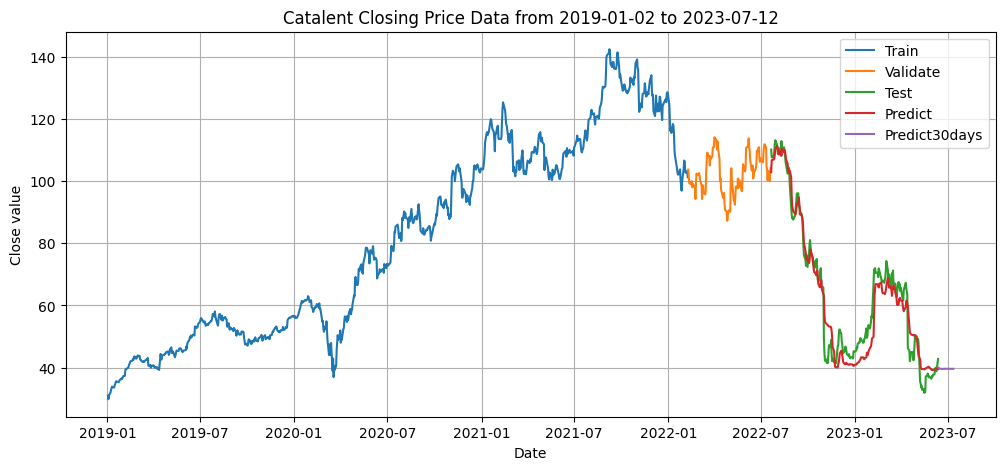

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_CTLT.png')
plt.show()